# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Albright, Gavin Fry

In [62]:
# Start with all of the includes we'll need for the project...

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import stats

#pca & clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering

#clustering performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score


In [64]:
# Begin...

In [65]:
df = pd.read_csv("reviews.csv")

In [66]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [67]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

## Feature-Scaling (Playtime After Negative Review)

In [69]:
# Make a mask for all rows within df that have recommended = false
mask = df[(df['is_recommended']==False)]

# Take a sample of 100 reviews with a random seed 100
data = mask.sample(n=100, random_state = 100, replace = False)

# Establish a new column, 'playtime_after_review' that takes the difference of playtime forever and at review.
data['playtime_after_review'] = data['playtime_forever'] - data['playtime_at_review']

# Determine the lower and upper range for 'playtime_after_review'
q_low = data["playtime_after_review"].quantile(0.05)
q_high  = data["playtime_after_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
data = data[(data["playtime_after_review"] < q_high) & (data["playtime_after_review"] > q_low)]

# Determine the lower and upper range for 'playtime_at_review'
q_low = data["playtime_at_review"].quantile(0.05)
q_high  = data["playtime_at_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
data = data[(data["playtime_at_review"] < q_high) & (data["playtime_at_review"] > q_low)]

# Sort the dataframe by 'playtime after review'
data = data.sort_values(by="playtime_after_review", ascending = True)

In [70]:
# Describing the sample we took...
data.playtime_after_review.describe()

count      37.000000
mean      337.945946
std       405.951895
min         1.000000
25%        43.000000
50%       170.000000
75%       431.000000
max      1321.000000
Name: playtime_after_review, dtype: float64

In [71]:
# Initialize scaler
scaler = MinMaxScaler()

# To scale playtime_after_review
scaler.fit(data['playtime_after_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
data['playtime_after_review']=scaler.transform(data['playtime_after_review'].values.reshape(-1,1))

# To scale playtime_after_review
scaler.fit(data['playtime_at_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
data['playtime_at_review_scaled']=scaler.transform(data['playtime_at_review'].values.reshape(-1,1))

# Instantiate the Label Encoder Object
label_encoder = LabelEncoder()

# Fit and transform the column into new column 'individual' to keep track of users sequentally instead of as an id
data['Individual'] = label_encoder.fit_transform(data['steamid'])

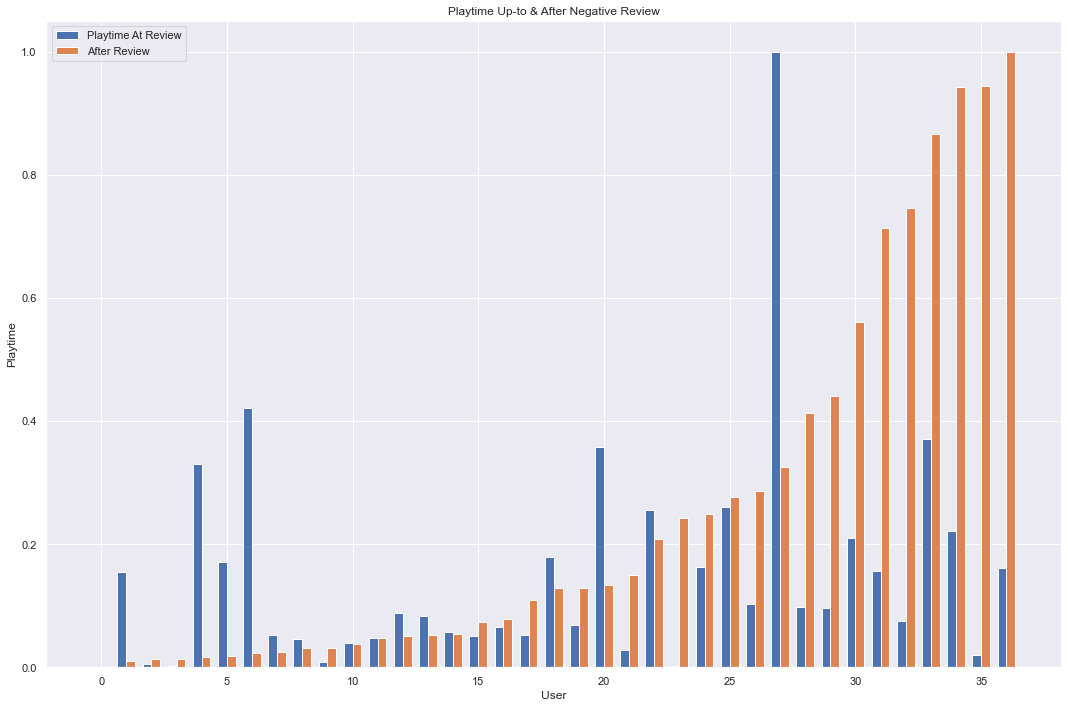

In [72]:
# Set the labels to be each individual within the sample
labels = data.Individual

# the label locations
x = np.arange(len(labels))
# the width of the bars
width = 0.35  

# Prepare the figure for sublots, since it will be a paired bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data.playtime_at_review_scaled, width, label='Playtime At Review')
rects2 = ax.bar(x + width/2, data.playtime_after_review, width, label='After Review')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Playtime')
ax.set_xlabel('User')
ax.set_title('Playtime Up-to & After Negative Review')
ax.legend()

# Set the layout and size for the figure.
fig.tight_layout()
fig.set_size_inches(15,10)

# Show the plot
plt.show()

## Clustering (Helpfulness vs Funniness)

In [73]:
# Take the two columns we want from OG df...
df2 = df[["votes_funny", "helpful_score"]]

# Drop 0's
df2= df2[df2['votes_funny'] != 0]
df2= df2[df2['helpful_score'] != 0]

# Take a sample of 5000 reviews with a random seed 1...
data = df2.sample(n=5000, random_state = 1, replace = False)

# Determine the lower and upper range for votes_funny
q_lowFunny = data["votes_funny"].quantile(0.10)
q_hiFunny  = data["votes_funny"].quantile(0.90)

# Determine the lower and upper range for helpful....
q_lowHelpful = data["helpful_score"].quantile(0.10)
q_hiHelpful  = data["helpful_score"].quantile(0.90)

# Take the previously determined lower and upper and use them to filter the data
df_filtered = data[(data["votes_funny"] < q_hiFunny) & (data["votes_funny"] > q_lowFunny)]
df_filtered = data[(data["helpful_score"] < q_hiHelpful) & (data["helpful_score"] > q_lowHelpful)]

# Define number of clusters
num_clusters = 10
 
# Creating instance of PCA and transforming the data from df_filtered to fit PCA
pca = PCA()
data_pca = pca.fit_transform(df_filtered)

# Creating the PC columns within pca_df for use in clustering
pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])

# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(df_filtered)
 
# Predict the target variable
pred=km.predict(df_filtered)

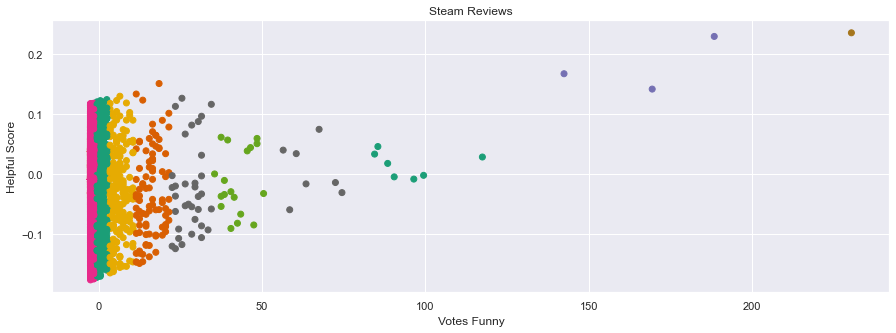

In [74]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

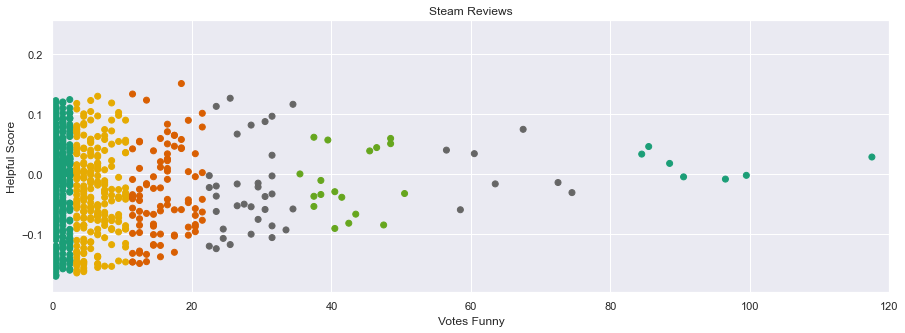

In [75]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Set the xlim for the second plot
plt.xlim([0, 120])
# Display the plot
plt.show()

# Ben

## Agglomerative Clustering

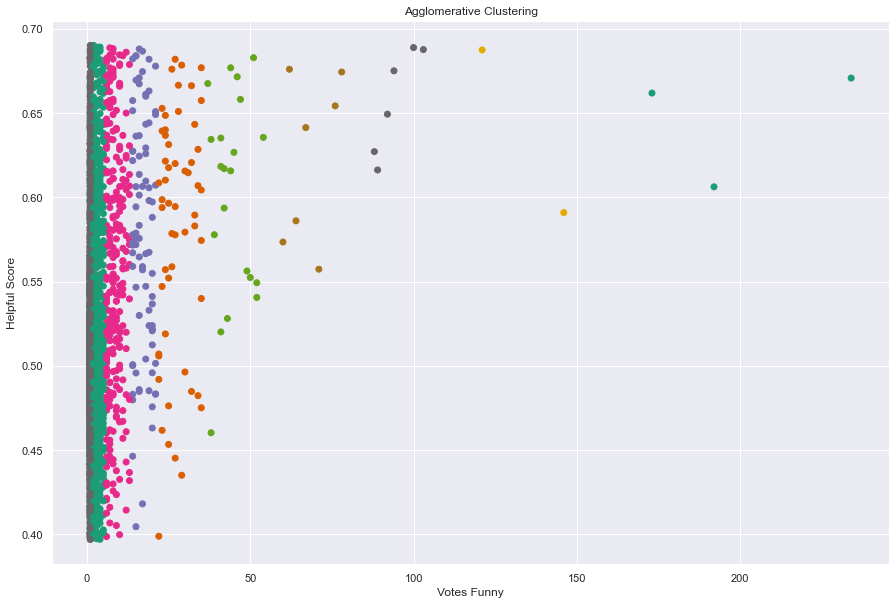

In [76]:
# Using the same dataset as Gavin used above, so that we can compare the performance of the two clustering algorithms
df_filtered

# Specify number of clusters
num_clusters = 10
 
# Create agglomerative clustering model
ac = AgglomerativeClustering(n_clusters = num_clusters, linkage='ward')
 
# Fit the Agglomerative Clustering model
ac.fit(df_filtered)
 
# Predict the target variable
pred_ac=ac.labels_

# Plot the Cluster
plt.scatter(df_filtered.votes_funny,df_filtered.helpful_score, c=pred_ac, marker="o", cmap = 'Dark2')

# Set title of the plot 
plt.title('Agglomerative Clustering')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

## Clustering Performance

In [77]:
clustering_df = pd.DataFrame({'labels': pred_ac, 'helpful score': df_filtered.helpful_score})
clustering_df

,labels,helpful score
402544,1,0.536617
1145891,8,0.476190
734749,8,0.623249
181659,1,0.442080
694250,1,0.399738
...,...,...
268891,1,0.489989
516315,1,0.537313
981123,4,0.558760
1018681,8,0.436508


In [78]:
print('k-means inertia')
print(km.inertia_)

k-means inertia
6213.919398736491


In [79]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=1)

In [80]:
#K Means Clustering Performance

# Specify the number of clusters
num_clusters = 10
 
# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(feature_train)
 
# Predict the target variable
predictions=km.predict(feature_test)
 
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(feature_test, predictions))
print("Silhouette Coefficient:", silhouette_score(feature_test, predictions))

# Calculate External performance evaluation measures
print("Adjusted Rand Score:", adjusted_rand_score(target_test, predictions))
print("Fowlkes Mallows Score:", fowlkes_mallows_score(target_test, predictions))

Davies-Bouldin Index: 0.47539717488016936
Silhouette Coefficient: 0.7534642027963078
Adjusted Rand Score: 0.005287394473201325
Fowlkes Mallows Score: 0.08198852831551721


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [84]:
# Agglomerative Clustering Performance

# Specify the number of clusters
num_clusters = 10
 
# Create and fit the KMeans model
ac = AgglomerativeClustering(n_clusters = num_clusters, linkage='ward')
ac.fit(feature_train)
 
# Predict the target variable
pred_ac=ac.labels_
 
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(feature_test, predictions))
print("Silhouette Coefficient:", silhouette_score(feature_test, predictions))

# Calculate External performance evaluation measures
print("Adjusted Rand Score:", adjusted_rand_score(target_test, predictions))
print("Fowlkes Mallows Score:", fowlkes_mallows_score(target_test, predictions))

Davies-Bouldin Index: 0.47539717488016936
Silhouette Coefficient: 0.7534642027963078
Adjusted Rand Score: 0.005287394473201325
Fowlkes Mallows Score: 0.08198852831551721


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


## Graphs

### Filtering and Sampling data for graphs

In [85]:
# Take the two columns we want from OG df...
df3 = df[["playtime_at_review", "is_recommended", "num_games_owned", "num_reviews", "helpful_score"]]

# Drop 0's
df3= df3[df3['helpful_score'] != 0]

# Determine the lower and upper range for helpful....
q_lowHelpful = df3["helpful_score"].quantile(0.05)
q_hiHelpful  = df3["helpful_score"].quantile(0.95)

#q_lowReview = df3["num_reviews"].quantile(0.05)
q_hiReview = df3["num_reviews"].quantile(0.95)

q_lowTime = df3["playtime_at_review"].quantile(0.05)
q_hiTime = df3["playtime_at_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
df_filtered = df3[(df3["helpful_score"] < q_hiHelpful) & (df3["helpful_score"] > q_lowHelpful)]
df_filtered = df_filtered[(df_filtered["num_reviews"] < q_hiReview)]
df_filtered = df_filtered[(df_filtered["playtime_at_review"] < q_hiTime) & (df_filtered["playtime_at_review"] > q_lowTime)]
df_filtered = df_filtered[(df_filtered["num_games_owned"] < 2500) & (df_filtered["num_games_owned"] > 10)]


# Take a sample of 5000 reviews with a random seed 1...
df_filtered = df_filtered.sample(n=5000, random_state = 1, replace = False)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 765819 to 236447
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playtime_at_review  5000 non-null   int64  
 1   is_recommended      5000 non-null   bool   
 2   num_games_owned     5000 non-null   int64  
 3   num_reviews         5000 non-null   int64  
 4   helpful_score       5000 non-null   float64
dtypes: bool(1), float64(1), int64(3)
memory usage: 200.2 KB


In [86]:
#Setting a consistent size for the figures below
sns.set(rc={'figure.figsize':(15,10)})

### Playtime x isRecommended

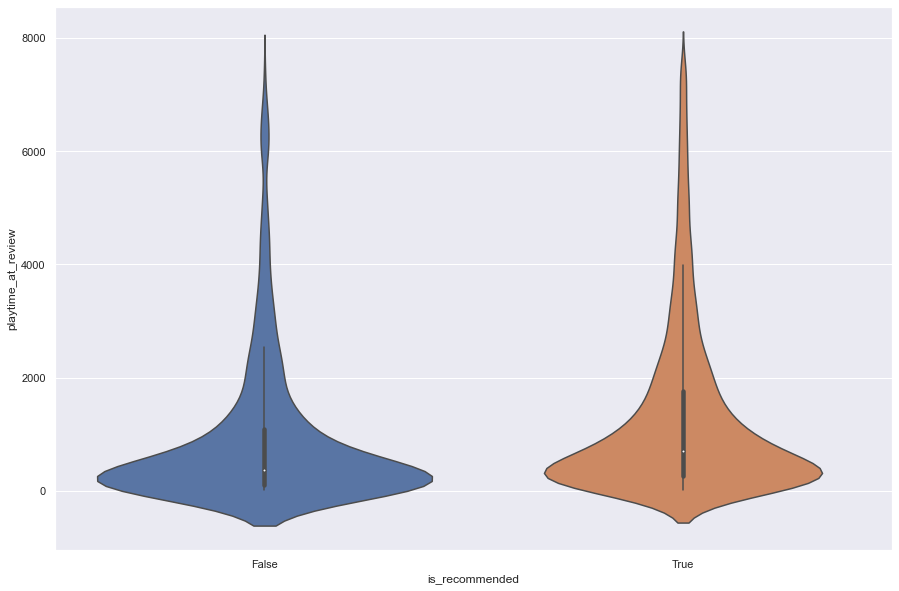

In [87]:
#use a stripplot with true/false on the y-axis and all of the playtimes plotted on x-axis
fig = sns.violinplot(x="is_recommended", y="playtime_at_review", data=df_filtered)

#df_filtered.head()

### num games owned x helpfulness of review

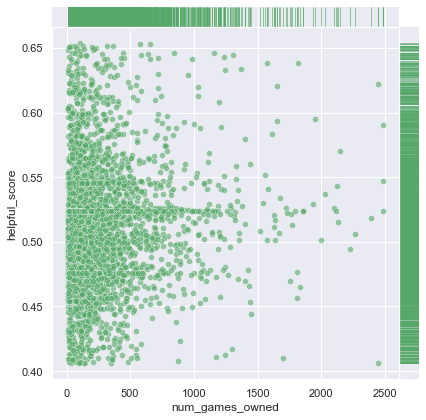

In [88]:
g = sns.JointGrid(data=df_filtered, x="num_games_owned", y="helpful_score", space=0, ratio=17)
g.plot_joint(sns.scatterplot, color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g", alpha=.6)



### num reviews x helpfulness of review

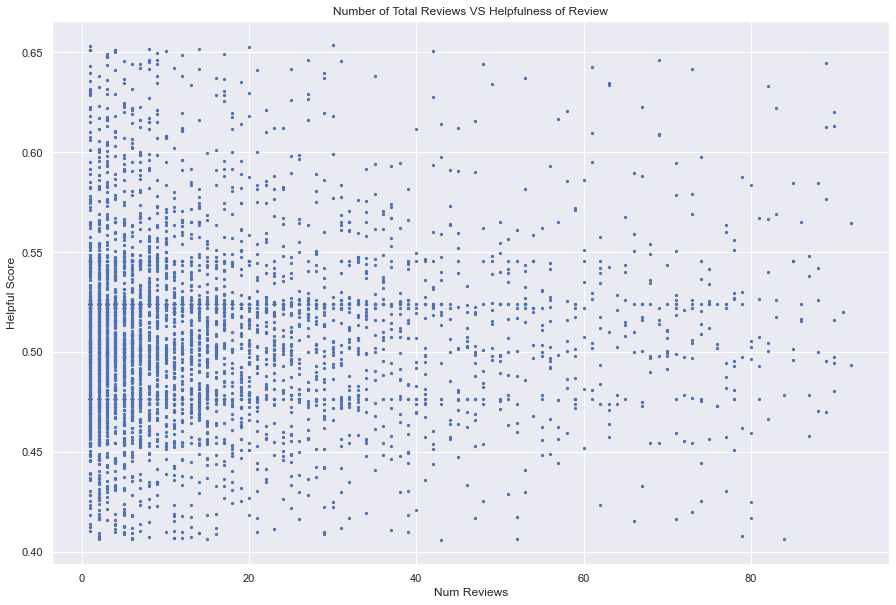

In [89]:
plt.scatter(df_filtered.num_reviews, df_filtered.helpful_score, s=5)
# Set title of the plot 
plt.title('Number of Total Reviews VS Helpfulness of Review')
# Set x-axis label
plt.xlabel('Num Reviews')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

# Logan


[Text(0.5, 0, 'Characters in Review'),
 Text(0, 0.5, 'Average Number of Games Owned')]

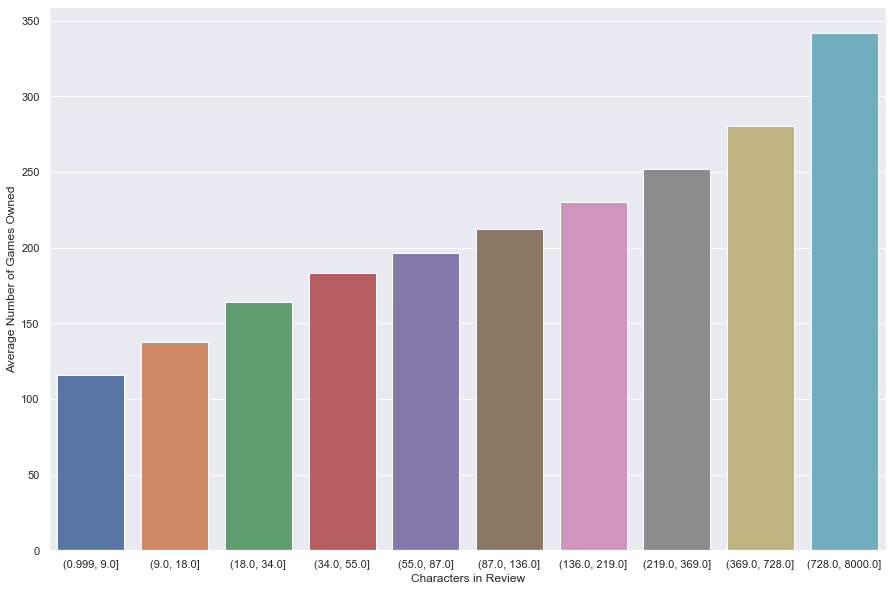

In [90]:
#Bar graphs using review character counts

#getting rid of large funny vote outliers 
df = df[df['votes_funny'] < 4294967292]

#cut into equal sized bins based on character lenght of review then get mean by grouping on bin

data = df.groupby(pd.qcut(df.review.map(lambda x: len(x)), q=10)).mean().reset_index()

#review lenght to number of games owned
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='num_games_owned', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Number of Games Owned")

[Text(0.5, 0, 'Characters in Review'), Text(0, 0.5, 'Average Helpful Score')]

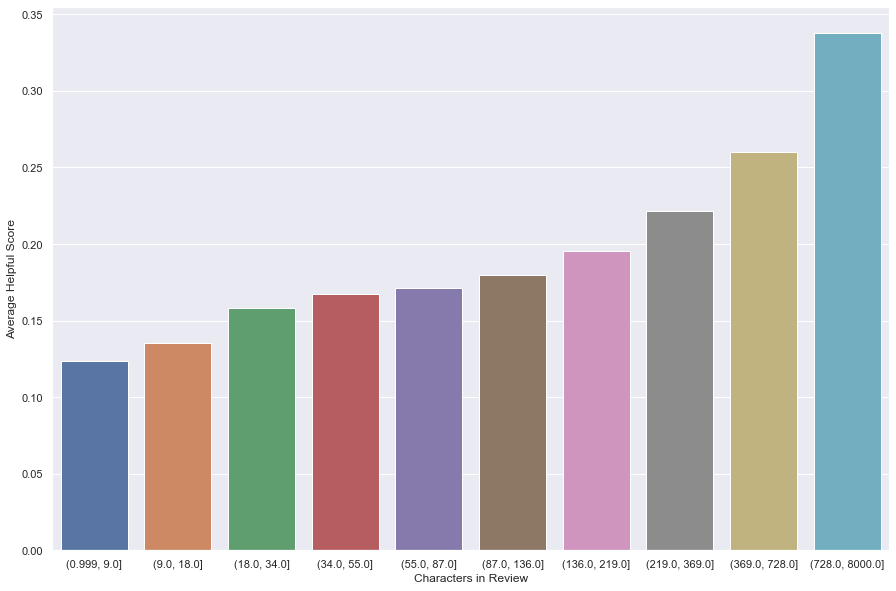

In [91]:
#review length to helpful score
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='helpful_score', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Helpful Score")

[Text(0.5, 0, 'Characters in Review'), Text(0, 0.5, 'Average Funny Votes')]

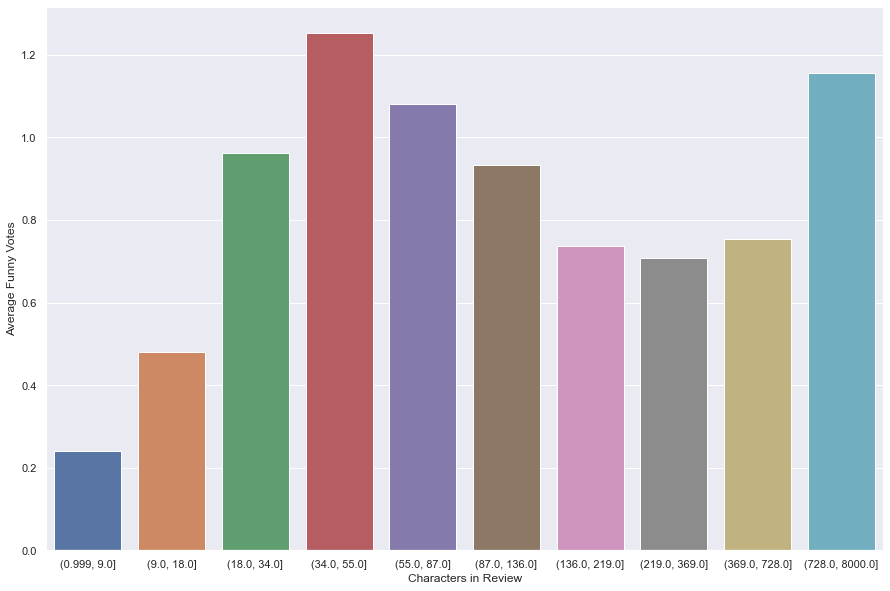

In [92]:
#review lengh to funny votes
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='votes_funny', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Funny Votes")

(0.0, 50000.0)

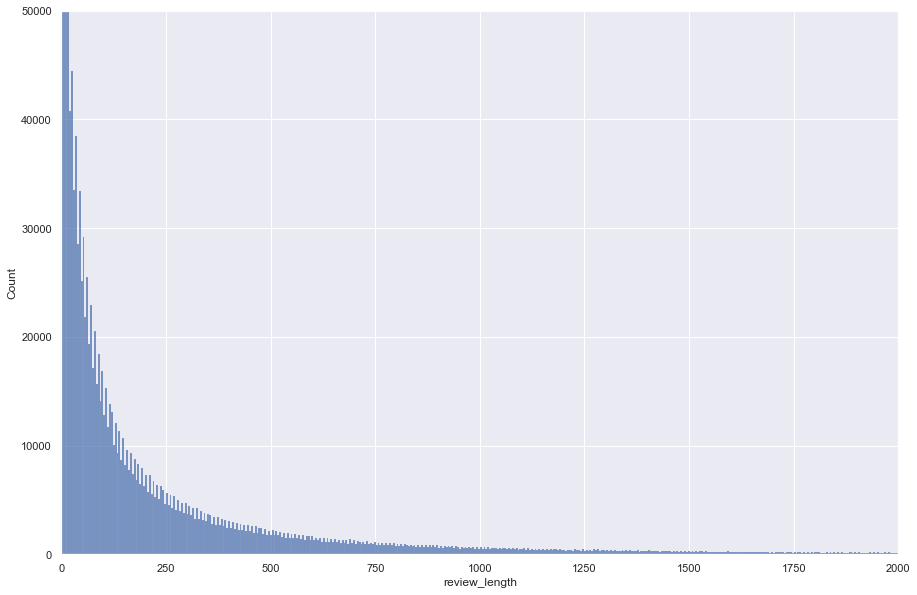

In [93]:
#histagram of review character lengths
df["review_length"] = df.review.map(lambda x: len(x))
sns.histplot(x='review_length', data=df)
plt.xlim(0,2000)
plt.ylim(0,50000)

In [ ]:
#word count
import re

def get_counts(reviews):
    word_count = {}
    for review in reviews:
        words = review.split()
        for word in words:
            word = re.sub('[^a-zA-Z]+', '', word)
            word = word.lower()
            if word in word_count:
                word_count[word] = word_count[word] + 1
            else: 
                word_count[word] =  1
    word_count.pop('', None)
    return word_count
#this takes a while to run
word_count_all = get_counts(df['review']) #all reviews words count
word_count_r = get_counts( df[df['is_recommended'] == True]["review"]) #words for recommended
word_count_nr = get_counts(df[df['is_recommended'] == False]["review"]) #words for not recommended
print("done")

In [ ]:
top_words = sorted(word_count_all.items(), key=lambda item: item[1], reverse=True)[:20]
word = list(zip(*top_words))[0]
count = list(zip(*top_words))[1]
plt.bar(word, count)

In [ ]:
#compare words between occurance between recommended and not
print("bugs")
print(word_count_nr["bugs"]/sum(word_count_nr.values()))
print(word_count_r["bugs"]/sum(word_count_r.values()))

print("graphics")
print(word_count_nr["graphics"]/sum(word_count_nr.values()))
print(word_count_r["graphics"]/sum(word_count_r.values()))

print("fun")
print(word_count_nr["fun"]/sum(word_count_nr.values()))
print(word_count_r["fun"]/sum(word_count_r.values()))

In [ ]:
#pair plot
pair_data = df[['helpful_score', 'playtime_at_review', 'num_games_owned', 'num_reviews']]
sns.pairplot(pair_data)

In [ ]:
#Pie chart for share of top 10 most reviewed games
top_ten_games = df.groupby("appid").count().reset_index().sort_values(ascending=False, by='is_recommended')['appid'][:10].to_list()
top_ten_values = df.groupby("appid").count().reset_index().sort_values(ascending=False, by='is_recommended')['steamid'][:10].to_list()
labels = ['Risk of Rain 2', 'Bloons TD 6', 'Raft', 'Beat Saber', 'Slay the Spire', 'Assassin\'s Creed Odyssey', 'Stick Fight: The Game'
          , 'Sekiro™: Shadows Die Twice', 'Resident Evil 2', 'Ravenfield']
plt.pie(top_ten_values, labels = labels, autopct='%.0f%%')

In [ ]:
#Violin plot for hours played of 10 most popular games
data = df.copy()
data = data[data['appid'].isin(top_ten_games)]
games = {
    632360: "Risk of Rain 2", 
    960090: "Bloons TD 6", 
    648800: "Raft", 
    620980: "Beat Saber",
    646570: "Slay the Spire",
    812140: "Assassin's Creed Odyssey",
    674940: "Stick Fight: The Game",
    814380: "Sekiro™: Shadows Die Twice",
    883710: "Resident Evil 2",
    636480: "Ravenfield"
}
data["game_name"] = data.appid.map(lambda x: games[x])

plt.figure(figsize=(27,15))
fig = sns.violinplot(x='appid', y='playtime_forever', data=data)
fig.set(xlabel='Game Name', ylabel='Hours Played')
plt.ylim(0,15000)